In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = 'C:/Users/Pro/Desktop/MachineLearning/ADvancedML/Newdata/Newdata/Train/HorseOnly'

In [3]:
image_size = 256
batch_size = 16 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [5]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


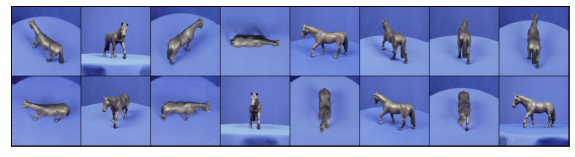

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 8 x 8

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 4 x 4

    nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 2048, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(True),
    # out: 2048 x 4 x 4

    nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 8 x 8

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 16 x 16

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 32 x 32

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 64 x 64

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)

torch.Size([16, 3, 256, 256])


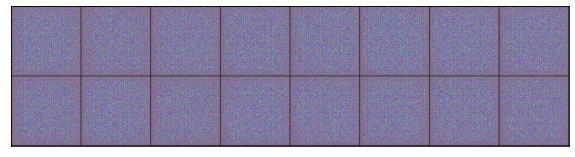

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'Generated_Horses1'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'GeneratedHorses{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=3)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=3).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(9, latent_size, 1, 1, device=device)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 60

* FIRST TIME TRAINING (epochs=60)

In [ ]:
training1 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/60], loss_g: 16.9062, loss_d: 0.0034, real_score: 0.9967, fake_score: 0.0001
Saving GeneratedHorses0001.png



Epoch [2/60], loss_g: 30.9825, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0002.png



Epoch [3/60], loss_g: 32.0394, loss_d: 2.9630, real_score: 1.0000, fake_score: 0.7915
Saving GeneratedHorses0003.png



Epoch [4/60], loss_g: 34.8155, loss_d: 0.3375, real_score: 0.7140, fake_score: 0.0000
Saving GeneratedHorses0004.png



Epoch [5/60], loss_g: 33.5220, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0005.png



Epoch [6/60], loss_g: 33.5063, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0006.png



Epoch [7/60], loss_g: 33.4669, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0007.png



Epoch [8/60], loss_g: 33.0655, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0008.png



Epoch [9/60], loss_g: 32.8475, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0009.png



Epoch [10/60], loss_g: 32.2455, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0010.png



Epoch [11/60], loss_g: 29.0736, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0011.png



Epoch [12/60], loss_g: 26.7122, loss_d: 1.1344, real_score: 1.0000, fake_score: 0.1755
Saving GeneratedHorses0012.png



Epoch [13/60], loss_g: 15.4596, loss_d: 0.7552, real_score: 0.5534, fake_score: 0.0000
Saving GeneratedHorses0013.png



Epoch [14/60], loss_g: 10.2420, loss_d: 3.0894, real_score: 1.0000, fake_score: 0.7094
Saving GeneratedHorses0014.png



Epoch [15/60], loss_g: 7.2653, loss_d: 0.2556, real_score: 0.9999, fake_score: 0.1678
Saving GeneratedHorses0015.png



Epoch [16/60], loss_g: 10.1912, loss_d: 0.2210, real_score: 0.8206, fake_score: 0.0005
Saving GeneratedHorses0016.png



Epoch [17/60], loss_g: 5.6700, loss_d: 0.0195, real_score: 0.9995, fake_score: 0.0186
Saving GeneratedHorses0017.png



Epoch [18/60], loss_g: 9.3520, loss_d: 0.3053, real_score: 0.7742, fake_score: 0.0077
Saving GeneratedHorses0018.png



Epoch [19/60], loss_g: 8.6174, loss_d: 0.0458, real_score: 1.0000, fake_score: 0.0439
Saving GeneratedHorses0019.png



Epoch [20/60], loss_g: 6.7642, loss_d: 0.0344, real_score: 0.9886, fake_score: 0.0223
Saving GeneratedHorses0020.png



Epoch [21/60], loss_g: 11.4052, loss_d: 6.5059, real_score: 0.0039, fake_score: 0.0002
Saving GeneratedHorses0021.png



Epoch [22/60], loss_g: 5.1374, loss_d: 1.4004, real_score: 1.0000, fake_score: 0.2253
Saving GeneratedHorses0022.png



Epoch [23/60], loss_g: 7.1774, loss_d: 0.0532, real_score: 0.9984, fake_score: 0.0498
Saving GeneratedHorses0023.png



Epoch [24/60], loss_g: 9.8351, loss_d: 0.0198, real_score: 0.9844, fake_score: 0.0040
Saving GeneratedHorses0024.png



Epoch [25/60], loss_g: 26.1528, loss_d: 1.2105, real_score: 1.0000, fake_score: 0.4194
Saving GeneratedHorses0025.png



Epoch [26/60], loss_g: 9.3080, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving GeneratedHorses0026.png



Epoch [27/60], loss_g: 6.7120, loss_d: 0.0057, real_score: 1.0000, fake_score: 0.0057
Saving GeneratedHorses0027.png



Epoch [28/60], loss_g: 7.8826, loss_d: 0.0048, real_score: 1.0000, fake_score: 0.0048
Saving GeneratedHorses0028.png



Epoch [29/60], loss_g: 7.8019, loss_d: 0.3150, real_score: 1.0000, fake_score: 0.1933
Saving GeneratedHorses0029.png



Epoch [30/60], loss_g: 11.3949, loss_d: 0.0266, real_score: 0.9743, fake_score: 0.0002
Saving GeneratedHorses0030.png



Epoch [31/60], loss_g: 8.3197, loss_d: 0.0023, real_score: 0.9986, fake_score: 0.0009
Saving GeneratedHorses0031.png



Epoch [32/60], loss_g: 5.0503, loss_d: 0.0501, real_score: 0.9997, fake_score: 0.0481
Saving GeneratedHorses0032.png



Epoch [33/60], loss_g: 4.7028, loss_d: 0.0166, real_score: 1.0000, fake_score: 0.0164
Saving GeneratedHorses0033.png



Epoch [34/60], loss_g: 4.7148, loss_d: 0.1793, real_score: 1.0000, fake_score: 0.1573
Saving GeneratedHorses0034.png



Epoch [35/60], loss_g: 6.0340, loss_d: 0.0214, real_score: 1.0000, fake_score: 0.0211
Saving GeneratedHorses0035.png



Epoch [36/60], loss_g: 10.6787, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving GeneratedHorses0036.png



Epoch [37/60], loss_g: 12.1849, loss_d: 0.0069, real_score: 0.9932, fake_score: 0.0000
Saving GeneratedHorses0037.png



Epoch [38/60], loss_g: 9.7308, loss_d: 0.0057, real_score: 0.9946, fake_score: 0.0003
Saving GeneratedHorses0038.png



Epoch [39/60], loss_g: 9.1966, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving GeneratedHorses0039.png



Epoch [40/60], loss_g: 9.6528, loss_d: 0.0021, real_score: 0.9999, fake_score: 0.0021
Saving GeneratedHorses0040.png



Epoch [41/60], loss_g: 7.1236, loss_d: 0.0016, real_score: 0.9997, fake_score: 0.0013
Saving GeneratedHorses0041.png



Epoch [42/60], loss_g: 6.1809, loss_d: 0.0218, real_score: 0.9999, fake_score: 0.0214
Saving GeneratedHorses0042.png



Epoch [43/60], loss_g: 7.8911, loss_d: 0.0020, real_score: 0.9995, fake_score: 0.0015
Saving GeneratedHorses0043.png



Epoch [44/60], loss_g: 7.2198, loss_d: 0.0075, real_score: 0.9981, fake_score: 0.0056
Saving GeneratedHorses0044.png



Epoch [45/60], loss_g: 8.7150, loss_d: 0.0058, real_score: 0.9948, fake_score: 0.0006
Saving GeneratedHorses0045.png



Epoch [46/60], loss_g: 6.1771, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving GeneratedHorses0046.png



Epoch [47/60], loss_g: 5.4543, loss_d: 0.0136, real_score: 0.9973, fake_score: 0.0107
Saving GeneratedHorses0047.png



Epoch [48/60], loss_g: 6.8879, loss_d: 0.0265, real_score: 1.0000, fake_score: 0.0254
Saving GeneratedHorses0048.png



Epoch [49/60], loss_g: 16.0944, loss_d: 7.5712, real_score: 0.0017, fake_score: 0.0000
Saving GeneratedHorses0049.png



Epoch [50/60], loss_g: 6.8299, loss_d: 0.6637, real_score: 1.0000, fake_score: 0.3730
Saving GeneratedHorses0050.png



Epoch [51/60], loss_g: 12.7244, loss_d: 0.0289, real_score: 0.9848, fake_score: 0.0130
Saving GeneratedHorses0051.png



Epoch [52/60], loss_g: 12.6718, loss_d: 1.9528, real_score: 1.0000, fake_score: 0.5003
Saving GeneratedHorses0052.png



Epoch [53/60], loss_g: 15.9336, loss_d: 1.5506, real_score: 0.9999, fake_score: 0.5703
Saving GeneratedHorses0053.png



Epoch [54/60], loss_g: 7.0625, loss_d: 0.0097, real_score: 0.9993, fake_score: 0.0090
Saving GeneratedHorses0054.png



Epoch [55/60], loss_g: 8.2980, loss_d: 0.0037, real_score: 0.9978, fake_score: 0.0016
Saving GeneratedHorses0055.png



Epoch [56/60], loss_g: 10.7684, loss_d: 3.1954, real_score: 0.1131, fake_score: 0.0000
Saving GeneratedHorses0056.png



Epoch [57/60], loss_g: 8.7173, loss_d: 0.2301, real_score: 0.7958, fake_score: 0.0003
Saving GeneratedHorses0057.png



Epoch [58/60], loss_g: 3.6566, loss_d: 0.1675, real_score: 1.0000, fake_score: 0.1271
Saving GeneratedHorses0058.png



Epoch [59/60], loss_g: 9.6450, loss_d: 0.0009, real_score: 0.9996, fake_score: 0.0005
Saving GeneratedHorses0059.png



Epoch [60/60], loss_g: 6.6169, loss_d: 0.0266, real_score: 0.9859, fake_score: 0.0119
Saving GeneratedHorses0060.png


In [ ]:
model_1=generator
PATH = "model_horse1.pt"
torch.save(model_1, PATH)

In [ ]:
data1 = torch.tensor(training1)
torch.save(data1, 'data_training1.pt')

* SECOND TIME TRAINNING (epochs=60)

In [ ]:
sample_dir = 'Generated_Horses2'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training2 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/60], loss_g: 10.0384, loss_d: 0.0166, real_score: 1.0000, fake_score: 0.0158
Saving GeneratedHorses0001.png



Epoch [2/60], loss_g: 9.0737, loss_d: 0.0068, real_score: 0.9964, fake_score: 0.0032
Saving GeneratedHorses0002.png



Epoch [3/60], loss_g: 11.1161, loss_d: 0.0065, real_score: 0.9997, fake_score: 0.0062
Saving GeneratedHorses0003.png



Epoch [4/60], loss_g: 7.9095, loss_d: 0.0093, real_score: 0.9989, fake_score: 0.0082
Saving GeneratedHorses0004.png



Epoch [5/60], loss_g: 10.8136, loss_d: 0.0303, real_score: 0.9999, fake_score: 0.0297
Saving GeneratedHorses0005.png



Epoch [6/60], loss_g: 9.5060, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving GeneratedHorses0006.png



Epoch [7/60], loss_g: 10.8173, loss_d: 0.0034, real_score: 0.9999, fake_score: 0.0034
Saving GeneratedHorses0007.png



Epoch [8/60], loss_g: 7.8395, loss_d: 0.0016, real_score: 0.9998, fake_score: 0.0014
Saving GeneratedHorses0008.png



Epoch [9/60], loss_g: 6.2491, loss_d: 0.0114, real_score: 1.0000, fake_score: 0.0113
Saving GeneratedHorses0009.png



Epoch [10/60], loss_g: 8.7683, loss_d: 0.0026, real_score: 0.9996, fake_score: 0.0022
Saving GeneratedHorses0010.png



Epoch [11/60], loss_g: 7.7954, loss_d: 0.0075, real_score: 0.9942, fake_score: 0.0016
Saving GeneratedHorses0011.png



Epoch [12/60], loss_g: 8.4166, loss_d: 0.0567, real_score: 1.0000, fake_score: 0.0503
Saving GeneratedHorses0012.png



Epoch [13/60], loss_g: 8.4226, loss_d: 0.0021, real_score: 0.9997, fake_score: 0.0018
Saving GeneratedHorses0013.png



Epoch [14/60], loss_g: 7.0574, loss_d: 0.0126, real_score: 0.9998, fake_score: 0.0123
Saving GeneratedHorses0014.png



Epoch [15/60], loss_g: 6.5648, loss_d: 0.0056, real_score: 0.9990, fake_score: 0.0046
Saving GeneratedHorses0015.png



Epoch [16/60], loss_g: 6.7115, loss_d: 7.0863, real_score: 0.0010, fake_score: 0.0009
Saving GeneratedHorses0016.png



Epoch [17/60], loss_g: 7.2672, loss_d: 0.1571, real_score: 0.9991, fake_score: 0.1271
Saving GeneratedHorses0017.png



Epoch [18/60], loss_g: 8.1316, loss_d: 0.0476, real_score: 0.9601, fake_score: 0.0066
Saving GeneratedHorses0018.png



Epoch [19/60], loss_g: 6.4525, loss_d: 0.0971, real_score: 0.9689, fake_score: 0.0624
Saving GeneratedHorses0019.png



Epoch [20/60], loss_g: 10.9357, loss_d: 0.0009, real_score: 0.9995, fake_score: 0.0004
Saving GeneratedHorses0020.png



Epoch [21/60], loss_g: 9.0504, loss_d: 0.0705, real_score: 0.9994, fake_score: 0.0666
Saving GeneratedHorses0021.png



Epoch [22/60], loss_g: 8.7604, loss_d: 0.0154, real_score: 0.9940, fake_score: 0.0093
Saving GeneratedHorses0022.png



Epoch [23/60], loss_g: 6.8249, loss_d: 0.0252, real_score: 0.9979, fake_score: 0.0227
Saving GeneratedHorses0023.png



Epoch [24/60], loss_g: 6.1343, loss_d: 0.0442, real_score: 0.9955, fake_score: 0.0386
Saving GeneratedHorses0024.png



Epoch [25/60], loss_g: 7.5008, loss_d: 0.0365, real_score: 0.9948, fake_score: 0.0306
Saving GeneratedHorses0025.png



Epoch [26/60], loss_g: 4.8822, loss_d: 0.0415, real_score: 0.9658, fake_score: 0.0060
Saving GeneratedHorses0026.png



Epoch [27/60], loss_g: 8.9563, loss_d: 0.0188, real_score: 0.9993, fake_score: 0.0180
Saving GeneratedHorses0027.png



Epoch [28/60], loss_g: 9.0628, loss_d: 0.0159, real_score: 0.9948, fake_score: 0.0107
Saving GeneratedHorses0028.png



Epoch [29/60], loss_g: 7.0821, loss_d: 0.0189, real_score: 0.9997, fake_score: 0.0184
Saving GeneratedHorses0029.png



Epoch [30/60], loss_g: 5.4373, loss_d: 2.2731, real_score: 0.2437, fake_score: 0.0000
Saving GeneratedHorses0030.png



Epoch [31/60], loss_g: 10.3702, loss_d: 0.0232, real_score: 0.9979, fake_score: 0.0193
Saving GeneratedHorses0031.png



Epoch [32/60], loss_g: 14.2056, loss_d: 0.0013, real_score: 0.9989, fake_score: 0.0002
Saving GeneratedHorses0032.png



Epoch [33/60], loss_g: 8.8776, loss_d: 0.0055, real_score: 0.9984, fake_score: 0.0039
Saving GeneratedHorses0033.png



Epoch [34/60], loss_g: 9.4093, loss_d: 0.0015, real_score: 0.9994, fake_score: 0.0009
Saving GeneratedHorses0034.png



Epoch [35/60], loss_g: 6.7988, loss_d: 0.0182, real_score: 0.9992, fake_score: 0.0172
Saving GeneratedHorses0035.png



Epoch [36/60], loss_g: 5.3104, loss_d: 0.0558, real_score: 0.9981, fake_score: 0.0519
Saving GeneratedHorses0036.png



Epoch [37/60], loss_g: 9.0960, loss_d: 0.0126, real_score: 0.9884, fake_score: 0.0008
Saving GeneratedHorses0037.png



Epoch [38/60], loss_g: 7.9317, loss_d: 0.0013, real_score: 0.9992, fake_score: 0.0005
Saving GeneratedHorses0038.png



Epoch [39/60], loss_g: 4.4531, loss_d: 0.0190, real_score: 0.9997, fake_score: 0.0184
Saving GeneratedHorses0039.png



Epoch [40/60], loss_g: 6.9244, loss_d: 0.0178, real_score: 0.9828, fake_score: 0.0005
Saving GeneratedHorses0040.png



Epoch [41/60], loss_g: 5.1979, loss_d: 0.0241, real_score: 0.9886, fake_score: 0.0125
Saving GeneratedHorses0041.png



Epoch [42/60], loss_g: 5.0765, loss_d: 0.0297, real_score: 0.9990, fake_score: 0.0283
Saving GeneratedHorses0042.png



Epoch [43/60], loss_g: 6.7158, loss_d: 0.0432, real_score: 0.9992, fake_score: 0.0413
Saving GeneratedHorses0043.png



Epoch [44/60], loss_g: 6.6371, loss_d: 0.0207, real_score: 0.9959, fake_score: 0.0164
Saving GeneratedHorses0044.png



Epoch [45/60], loss_g: 5.4687, loss_d: 0.0087, real_score: 0.9999, fake_score: 0.0085
Saving GeneratedHorses0045.png



Epoch [46/60], loss_g: 6.1890, loss_d: 0.0211, real_score: 0.9985, fake_score: 0.0194
Saving GeneratedHorses0046.png



Epoch [47/60], loss_g: 7.7769, loss_d: 0.0031, real_score: 0.9976, fake_score: 0.0007
Saving GeneratedHorses0047.png



Epoch [48/60], loss_g: 7.1164, loss_d: 0.0046, real_score: 0.9995, fake_score: 0.0041
Saving GeneratedHorses0048.png



Epoch [49/60], loss_g: 5.0616, loss_d: 0.0236, real_score: 0.9988, fake_score: 0.0222
Saving GeneratedHorses0049.png



Epoch [50/60], loss_g: 6.0108, loss_d: 0.0158, real_score: 0.9981, fake_score: 0.0139
Saving GeneratedHorses0050.png



Epoch [51/60], loss_g: 8.3175, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saving GeneratedHorses0051.png



Epoch [52/60], loss_g: 10.7660, loss_d: 0.0027, real_score: 0.9998, fake_score: 0.0026
Saving GeneratedHorses0052.png



Epoch [53/60], loss_g: 7.4139, loss_d: 0.0008, real_score: 0.9993, fake_score: 0.0001
Saving GeneratedHorses0053.png



Epoch [54/60], loss_g: 5.6376, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving GeneratedHorses0054.png



Epoch [55/60], loss_g: 5.8310, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving GeneratedHorses0055.png



Epoch [56/60], loss_g: 10.4841, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving GeneratedHorses0056.png



Epoch [57/60], loss_g: 9.9390, loss_d: 0.0017, real_score: 0.9986, fake_score: 0.0003
Saving GeneratedHorses0057.png



Epoch [58/60], loss_g: 8.0598, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0007
Saving GeneratedHorses0058.png



Epoch [59/60], loss_g: 7.2914, loss_d: 0.0037, real_score: 0.9996, fake_score: 0.0033
Saving GeneratedHorses0059.png



Epoch [60/60], loss_g: 5.7144, loss_d: 0.0032, real_score: 1.0000, fake_score: 0.0032
Saving GeneratedHorses0060.png


In [ ]:
model_2=generator
PATH = "model_horse2.pt"
torch.save(model_2, PATH)

In [ ]:
data2 = torch.tensor(training2)
torch.save(data2, 'data_training2.pt')

* THIRD TIME TRAINNING (epochs=60)

In [ ]:
lr = 0.0002
epochs = 120

In [ ]:
sample_dir = 'Generated_Horses3'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training3 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/120], loss_g: 10.2976, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0003
Saving GeneratedHorses0001.png



Epoch [2/120], loss_g: 11.1112, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving GeneratedHorses0002.png



Epoch [3/120], loss_g: 11.4143, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving GeneratedHorses0003.png



Epoch [4/120], loss_g: 9.4257, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0004.png



Epoch [5/120], loss_g: 13.2500, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0005.png



Epoch [6/120], loss_g: 9.2083, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0006.png



Epoch [7/120], loss_g: 9.4743, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0007.png



Epoch [8/120], loss_g: 13.2703, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0008.png



Epoch [9/120], loss_g: 13.0990, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0009.png



Epoch [10/120], loss_g: 12.4691, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0010.png



Epoch [11/120], loss_g: 15.2279, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0011.png



Epoch [12/120], loss_g: 13.2768, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0012.png



Epoch [13/120], loss_g: 11.0580, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0013.png



Epoch [14/120], loss_g: 12.1310, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0014.png



Epoch [15/120], loss_g: 20.2097, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0015.png



Epoch [16/120], loss_g: 13.5446, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0016.png



Epoch [17/120], loss_g: 13.8912, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving GeneratedHorses0017.png



Epoch [18/120], loss_g: 12.3280, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving GeneratedHorses0018.png



Epoch [19/120], loss_g: 0.0199, loss_d: 0.5071, real_score: 0.6819, fake_score: 0.0015
Saving GeneratedHorses0019.png



Epoch [20/120], loss_g: 10.2067, loss_d: 10.7057, real_score: 0.0006, fake_score: 0.0000
Saving GeneratedHorses0020.png



Epoch [21/120], loss_g: 11.2946, loss_d: 3.9684, real_score: 1.0000, fake_score: 0.8207
Saving GeneratedHorses0021.png



Epoch [22/120], loss_g: 3.6258, loss_d: 0.5197, real_score: 0.8265, fake_score: 0.2068
Saving GeneratedHorses0022.png



Epoch [23/120], loss_g: 6.7916, loss_d: 0.0537, real_score: 0.9992, fake_score: 0.0473
Saving GeneratedHorses0023.png



Epoch [24/120], loss_g: 4.2432, loss_d: 0.0915, real_score: 0.9999, fake_score: 0.0865
Saving GeneratedHorses0024.png



Epoch [25/120], loss_g: 4.5940, loss_d: 0.4530, real_score: 1.0000, fake_score: 0.3450
Saving GeneratedHorses0025.png



Epoch [26/120], loss_g: 11.0482, loss_d: 0.2939, real_score: 0.9979, fake_score: 0.1859
Saving GeneratedHorses0026.png



Epoch [27/120], loss_g: 15.1328, loss_d: 0.8458, real_score: 0.5584, fake_score: 0.0001
Saving GeneratedHorses0027.png



Epoch [28/120], loss_g: 5.7503, loss_d: 0.0074, real_score: 0.9999, fake_score: 0.0072
Saving GeneratedHorses0028.png



Epoch [29/120], loss_g: 7.1953, loss_d: 0.0081, real_score: 1.0000, fake_score: 0.0080
Saving GeneratedHorses0029.png



Epoch [30/120], loss_g: 27.9773, loss_d: 0.0677, real_score: 0.9355, fake_score: 0.0000
Saving GeneratedHorses0030.png



Epoch [31/120], loss_g: 17.8238, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving GeneratedHorses0031.png



Epoch [32/120], loss_g: 7.2149, loss_d: 0.0125, real_score: 1.0000, fake_score: 0.0122
Saving GeneratedHorses0032.png



Epoch [33/120], loss_g: 13.0605, loss_d: 0.1813, real_score: 0.9988, fake_score: 0.1474
Saving GeneratedHorses0033.png



Epoch [34/120], loss_g: 6.9799, loss_d: 0.0047, real_score: 0.9989, fake_score: 0.0036
Saving GeneratedHorses0034.png



Epoch [35/120], loss_g: 18.8038, loss_d: 5.4823, real_score: 0.4474, fake_score: 0.0000
Saving GeneratedHorses0035.png



Epoch [36/120], loss_g: 8.6235, loss_d: 0.0047, real_score: 0.9958, fake_score: 0.0004
Saving GeneratedHorses0036.png



Epoch [37/120], loss_g: 8.5162, loss_d: 0.1847, real_score: 0.9994, fake_score: 0.1247
Saving GeneratedHorses0037.png



Epoch [38/120], loss_g: 17.5646, loss_d: 0.4025, real_score: 0.9999, fake_score: 0.2123
Saving GeneratedHorses0038.png



Epoch [39/120], loss_g: 9.7526, loss_d: 0.1811, real_score: 0.8356, fake_score: 0.0000
Saving GeneratedHorses0039.png



Epoch [40/120], loss_g: 10.7687, loss_d: 0.0958, real_score: 0.9993, fake_score: 0.0790
Saving GeneratedHorses0040.png



Epoch [41/120], loss_g: 8.3219, loss_d: 0.0432, real_score: 0.9660, fake_score: 0.0079
Saving GeneratedHorses0041.png



Epoch [42/120], loss_g: 22.5661, loss_d: 0.4173, real_score: 0.9683, fake_score: 0.2506
Saving GeneratedHorses0042.png



Epoch [43/120], loss_g: 15.0688, loss_d: 0.0049, real_score: 0.9952, fake_score: 0.0001
Saving GeneratedHorses0043.png



Epoch [44/120], loss_g: 18.3697, loss_d: 5.3987, real_score: 0.9997, fake_score: 0.7704
Saving GeneratedHorses0044.png



Epoch [45/120], loss_g: 15.7625, loss_d: 0.0532, real_score: 0.9497, fake_score: 0.0001
Saving GeneratedHorses0045.png



Epoch [46/120], loss_g: 12.2000, loss_d: 0.0014, real_score: 0.9995, fake_score: 0.0008
Saving GeneratedHorses0046.png



Epoch [47/120], loss_g: 7.7375, loss_d: 0.0224, real_score: 1.0000, fake_score: 0.0207
Saving GeneratedHorses0047.png



Epoch [48/120], loss_g: 6.9324, loss_d: 0.8270, real_score: 0.9998, fake_score: 0.4518
Saving GeneratedHorses0048.png



Epoch [49/120], loss_g: 18.8008, loss_d: 0.0316, real_score: 0.9694, fake_score: 0.0000
Saving GeneratedHorses0049.png



Epoch [50/120], loss_g: 9.9054, loss_d: 0.0044, real_score: 0.9960, fake_score: 0.0004
Saving GeneratedHorses0050.png



Epoch [51/120], loss_g: 9.9751, loss_d: 0.0034, real_score: 0.9985, fake_score: 0.0018
Saving GeneratedHorses0051.png



Epoch [52/120], loss_g: 10.1126, loss_d: 0.0009, real_score: 0.9992, fake_score: 0.0001
Saving GeneratedHorses0052.png



Epoch [53/120], loss_g: 6.8820, loss_d: 0.0017, real_score: 0.9994, fake_score: 0.0011
Saving GeneratedHorses0053.png



Epoch [54/120], loss_g: 4.4739, loss_d: 0.0090, real_score: 0.9998, fake_score: 0.0087
Saving GeneratedHorses0054.png



Epoch [55/120], loss_g: 6.6211, loss_d: 0.1366, real_score: 0.9995, fake_score: 0.1130
Saving GeneratedHorses0055.png



Epoch [56/120], loss_g: 6.8451, loss_d: 0.0843, real_score: 0.9479, fake_score: 0.0280
Saving GeneratedHorses0056.png



Epoch [57/120], loss_g: 17.0141, loss_d: 3.0852, real_score: 0.0480, fake_score: 0.0000
Saving GeneratedHorses0057.png



Epoch [58/120], loss_g: 8.5830, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving GeneratedHorses0058.png



Epoch [59/120], loss_g: 4.3442, loss_d: 0.0823, real_score: 0.9975, fake_score: 0.0750
Saving GeneratedHorses0059.png



Epoch [60/120], loss_g: 20.6851, loss_d: 0.0897, real_score: 0.9144, fake_score: 0.0000
Saving GeneratedHorses0060.png



Epoch [61/120], loss_g: 10.1228, loss_d: 0.0029, real_score: 0.9973, fake_score: 0.0002
Saving GeneratedHorses0061.png



Epoch [62/120], loss_g: 10.8234, loss_d: 0.0022, real_score: 0.9999, fake_score: 0.0021
Saving GeneratedHorses0062.png



Epoch [63/120], loss_g: 11.3636, loss_d: 0.0016, real_score: 0.9985, fake_score: 0.0001
Saving GeneratedHorses0063.png



Epoch [64/120], loss_g: 9.2838, loss_d: 0.0044, real_score: 0.9971, fake_score: 0.0015
Saving GeneratedHorses0064.png



Epoch [65/120], loss_g: 9.8843, loss_d: 0.0036, real_score: 0.9988, fake_score: 0.0024
Saving GeneratedHorses0065.png



Epoch [66/120], loss_g: 8.5838, loss_d: 0.0033, real_score: 0.9998, fake_score: 0.0031
Saving GeneratedHorses0066.png



Epoch [67/120], loss_g: 9.4661, loss_d: 0.0015, real_score: 0.9996, fake_score: 0.0010
Saving GeneratedHorses0067.png



Epoch [68/120], loss_g: 9.5762, loss_d: 0.0030, real_score: 0.9980, fake_score: 0.0010
Saving GeneratedHorses0068.png



Epoch [69/120], loss_g: 9.9368, loss_d: 0.0009, real_score: 0.9998, fake_score: 0.0007
Saving GeneratedHorses0069.png



Epoch [70/120], loss_g: 9.3841, loss_d: 0.0051, real_score: 0.9999, fake_score: 0.0050
Saving GeneratedHorses0070.png



Epoch [71/120], loss_g: 10.3521, loss_d: 0.0078, real_score: 0.9937, fake_score: 0.0015
Saving GeneratedHorses0071.png



Epoch [72/120], loss_g: 10.5652, loss_d: 0.0052, real_score: 0.9985, fake_score: 0.0037
Saving GeneratedHorses0072.png



Epoch [73/120], loss_g: 9.1989, loss_d: 0.0350, real_score: 0.9999, fake_score: 0.0339
Saving GeneratedHorses0073.png



Epoch [74/120], loss_g: 10.4873, loss_d: 0.0016, real_score: 1.0000, fake_score: 0.0016
Saving GeneratedHorses0074.png



Epoch [75/120], loss_g: 10.3915, loss_d: 0.0021, real_score: 1.0000, fake_score: 0.0021
Saving GeneratedHorses0075.png



Epoch [76/120], loss_g: 7.2104, loss_d: 0.0030, real_score: 0.9999, fake_score: 0.0029
Saving GeneratedHorses0076.png



Epoch [77/120], loss_g: 8.6264, loss_d: 0.0023, real_score: 0.9999, fake_score: 0.0022
Saving GeneratedHorses0077.png



Epoch [78/120], loss_g: 7.9996, loss_d: 0.0019, real_score: 0.9986, fake_score: 0.0005
Saving GeneratedHorses0078.png



Epoch [79/120], loss_g: 11.5927, loss_d: 0.0011, real_score: 0.9992, fake_score: 0.0003
Saving GeneratedHorses0079.png



Epoch [80/120], loss_g: 10.4690, loss_d: 0.0033, real_score: 0.9998, fake_score: 0.0030
Saving GeneratedHorses0080.png



Epoch [81/120], loss_g: 10.2269, loss_d: 0.0053, real_score: 0.9999, fake_score: 0.0052
Saving GeneratedHorses0081.png



Epoch [82/120], loss_g: 7.3959, loss_d: 0.0087, real_score: 1.0000, fake_score: 0.0086
Saving GeneratedHorses0082.png



Epoch [83/120], loss_g: 7.5047, loss_d: 0.0132, real_score: 1.0000, fake_score: 0.0130
Saving GeneratedHorses0083.png



Epoch [84/120], loss_g: 7.8148, loss_d: 0.0052, real_score: 1.0000, fake_score: 0.0052
Saving GeneratedHorses0084.png



Epoch [85/120], loss_g: 7.7834, loss_d: 0.0118, real_score: 0.9985, fake_score: 0.0102
Saving GeneratedHorses0085.png



Epoch [86/120], loss_g: 8.2902, loss_d: 0.0008, real_score: 1.0000, fake_score: 0.0007
Saving GeneratedHorses0086.png



Epoch [87/120], loss_g: 10.5094, loss_d: 0.0050, real_score: 0.9990, fake_score: 0.0040
Saving GeneratedHorses0087.png



Epoch [88/120], loss_g: 7.3062, loss_d: 0.0079, real_score: 0.9973, fake_score: 0.0053
Saving GeneratedHorses0088.png



Epoch [89/120], loss_g: 8.8548, loss_d: 0.0080, real_score: 0.9989, fake_score: 0.0069
Saving GeneratedHorses0089.png



Epoch [90/120], loss_g: 8.4167, loss_d: 0.0088, real_score: 1.0000, fake_score: 0.0087
Saving GeneratedHorses0090.png



Epoch [91/120], loss_g: 7.0717, loss_d: 0.0281, real_score: 1.0000, fake_score: 0.0275
Saving GeneratedHorses0091.png



Epoch [92/120], loss_g: 8.4237, loss_d: 0.0025, real_score: 0.9998, fake_score: 0.0023
Saving GeneratedHorses0092.png



Epoch [93/120], loss_g: 7.9715, loss_d: 0.0030, real_score: 0.9994, fake_score: 0.0024
Saving GeneratedHorses0093.png



Epoch [94/120], loss_g: 8.4536, loss_d: 0.0071, real_score: 0.9997, fake_score: 0.0067
Saving GeneratedHorses0094.png



Epoch [95/120], loss_g: 9.6449, loss_d: 0.0029, real_score: 1.0000, fake_score: 0.0029
Saving GeneratedHorses0095.png



Epoch [96/120], loss_g: 6.8445, loss_d: 0.0129, real_score: 1.0000, fake_score: 0.0128
Saving GeneratedHorses0096.png



Epoch [97/120], loss_g: 10.3718, loss_d: 0.0045, real_score: 0.9956, fake_score: 0.0001
Saving GeneratedHorses0097.png



Epoch [98/120], loss_g: 11.2706, loss_d: 0.0015, real_score: 1.0000, fake_score: 0.0014
Saving GeneratedHorses0098.png



Epoch [99/120], loss_g: 8.0323, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving GeneratedHorses0099.png



Epoch [100/120], loss_g: 8.0629, loss_d: 0.0011, real_score: 1.0000, fake_score: 0.0011
Saving GeneratedHorses0100.png



Epoch [101/120], loss_g: 7.6793, loss_d: 0.0014, real_score: 1.0000, fake_score: 0.0014
Saving GeneratedHorses0101.png



Epoch [102/120], loss_g: 7.2029, loss_d: 0.0061, real_score: 1.0000, fake_score: 0.0061
Saving GeneratedHorses0102.png



Epoch [103/120], loss_g: 7.6563, loss_d: 0.0034, real_score: 1.0000, fake_score: 0.0034
Saving GeneratedHorses0103.png



Epoch [104/120], loss_g: 10.0913, loss_d: 0.0043, real_score: 1.0000, fake_score: 0.0043
Saving GeneratedHorses0104.png



Epoch [105/120], loss_g: 7.8692, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving GeneratedHorses0105.png



Epoch [106/120], loss_g: 8.4201, loss_d: 0.0025, real_score: 0.9980, fake_score: 0.0005
Saving GeneratedHorses0106.png



Epoch [107/120], loss_g: 7.4094, loss_d: 0.0042, real_score: 1.0000, fake_score: 0.0042
Saving GeneratedHorses0107.png



Epoch [108/120], loss_g: 6.4563, loss_d: 0.0103, real_score: 1.0000, fake_score: 0.0103
Saving GeneratedHorses0108.png



Epoch [109/120], loss_g: 6.5638, loss_d: 0.0262, real_score: 1.0000, fake_score: 0.0256
Saving GeneratedHorses0109.png



Epoch [110/120], loss_g: 8.6391, loss_d: 0.0016, real_score: 1.0000, fake_score: 0.0016
Saving GeneratedHorses0110.png



Epoch [111/120], loss_g: 7.2791, loss_d: 0.0025, real_score: 0.9982, fake_score: 0.0007
Saving GeneratedHorses0111.png



Epoch [112/120], loss_g: 8.2292, loss_d: 0.0054, real_score: 0.9998, fake_score: 0.0053
Saving GeneratedHorses0112.png



Epoch [113/120], loss_g: 6.4883, loss_d: 0.0090, real_score: 0.9999, fake_score: 0.0089
Saving GeneratedHorses0113.png



Epoch [114/120], loss_g: 8.7115, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving GeneratedHorses0114.png



Epoch [115/120], loss_g: 7.7442, loss_d: 0.0019, real_score: 0.9987, fake_score: 0.0006
Saving GeneratedHorses0115.png



Epoch [116/120], loss_g: 6.4000, loss_d: 0.0030, real_score: 0.9984, fake_score: 0.0014
Saving GeneratedHorses0116.png



Epoch [117/120], loss_g: 5.4847, loss_d: 0.0066, real_score: 1.0000, fake_score: 0.0066
Saving GeneratedHorses0117.png



Epoch [118/120], loss_g: 9.5766, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving GeneratedHorses0118.png



Epoch [119/120], loss_g: 11.2467, loss_d: 0.0020, real_score: 0.9983, fake_score: 0.0003
Saving GeneratedHorses0119.png



Epoch [120/120], loss_g: 6.9429, loss_d: 0.0080, real_score: 0.9999, fake_score: 0.0079
Saving GeneratedHorses0120.png


In [ ]:
model_3=generator
PATH = "model_horse3.pt"
torch.save(model_3, PATH)

In [ ]:
data3 = torch.tensor(training3)
torch.save(data3, 'data_training3.pt')

* FORTH TIME TRAINING (epochs=10)

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
sample_dir = 'Generated_Horses4'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training4 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/10], loss_g: 7.3275, loss_d: 0.0044, real_score: 0.9967, fake_score: 0.0011
Saving GeneratedHorses0001.png



Epoch [2/10], loss_g: 6.7528, loss_d: 0.1305, real_score: 0.9998, fake_score: 0.1124
Saving GeneratedHorses0002.png



Epoch [3/10], loss_g: 5.6627, loss_d: 0.6965, real_score: 0.7644, fake_score: 0.0009
Saving GeneratedHorses0003.png



Epoch [4/10], loss_g: 10.0994, loss_d: 0.2647, real_score: 0.7878, fake_score: 0.0047
Saving GeneratedHorses0004.png



Epoch [5/10], loss_g: 8.5817, loss_d: 0.0823, real_score: 0.9319, fake_score: 0.0056
Saving GeneratedHorses0005.png



Epoch [6/10], loss_g: 8.6264, loss_d: 0.8632, real_score: 0.9926, fake_score: 0.2527
Saving GeneratedHorses0006.png



Epoch [7/10], loss_g: 8.6522, loss_d: 0.2128, real_score: 0.8257, fake_score: 0.0002
Saving GeneratedHorses0007.png



Epoch [8/10], loss_g: 9.6159, loss_d: 0.0798, real_score: 0.9305, fake_score: 0.0010
Saving GeneratedHorses0008.png



Epoch [9/10], loss_g: 5.1074, loss_d: 0.0192, real_score: 0.9947, fake_score: 0.0136
Saving GeneratedHorses0009.png



Epoch [10/10], loss_g: 11.6373, loss_d: 0.1352, real_score: 0.8962, fake_score: 0.0052
Saving GeneratedHorses0010.png


In [ ]:
model_4=generator
PATH = "model_horse4.pt"
torch.save(model_4, PATH)

In [ ]:
data4 = torch.tensor(training4)
torch.save(data4, 'data_training4.pt')

* FIFTH TIME TRAINING (10 epochs)

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
sample_dir = 'Generated_Horses5'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training5 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/10], loss_g: 8.4532, loss_d: 0.0239, real_score: 0.9994, fake_score: 0.0224
Saving GeneratedHorses0001.png



Epoch [2/10], loss_g: 6.4253, loss_d: 0.0320, real_score: 0.9754, fake_score: 0.0061
Saving GeneratedHorses0002.png



Epoch [3/10], loss_g: 7.1886, loss_d: 0.0291, real_score: 1.0000, fake_score: 0.0283
Saving GeneratedHorses0003.png



Epoch [4/10], loss_g: 5.7349, loss_d: 0.0332, real_score: 0.9995, fake_score: 0.0319
Saving GeneratedHorses0004.png



Epoch [5/10], loss_g: 13.4933, loss_d: 0.8455, real_score: 1.0000, fake_score: 0.2895
Saving GeneratedHorses0005.png



Epoch [6/10], loss_g: 13.1784, loss_d: 0.1028, real_score: 0.9522, fake_score: 0.0471
Saving GeneratedHorses0006.png



Epoch [7/10], loss_g: 14.5433, loss_d: 0.5935, real_score: 0.9953, fake_score: 0.2993
Saving GeneratedHorses0007.png



Epoch [8/10], loss_g: 2.8414, loss_d: 20.2190, real_score: 0.9999, fake_score: 0.3790
Saving GeneratedHorses0008.png



Epoch [9/10], loss_g: 5.2743, loss_d: 0.1888, real_score: 0.9990, fake_score: 0.1369
Saving GeneratedHorses0009.png



Epoch [10/10], loss_g: 3.3353, loss_d: 0.0334, real_score: 0.9994, fake_score: 0.0317
Saving GeneratedHorses0010.png


In [ ]:
model_5=generator
PATH = "model_horse5.pt"
torch.save(model_5, PATH)

In [ ]:
data5 = torch.tensor(training5)
torch.save(data5, 'data_training5.pt')

* SIXTH TRAINING (epochs =20)

In [ ]:
lr = 0.0002
epochs = 20

In [ ]:
sample_dir = 'Generated_Horses6'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training6 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/20], loss_g: 14.3824, loss_d: 0.1494, real_score: 0.9658, fake_score: 0.0985
Saving GeneratedHorses0001.png



Epoch [2/20], loss_g: 12.3119, loss_d: 0.0538, real_score: 0.9516, fake_score: 0.0016
Saving GeneratedHorses0002.png



Epoch [3/20], loss_g: 5.2733, loss_d: 0.4873, real_score: 0.7893, fake_score: 0.0272
Saving GeneratedHorses0003.png



Epoch [4/20], loss_g: 2.5584, loss_d: 0.2618, real_score: 0.7868, fake_score: 0.0020
Saving GeneratedHorses0004.png



Epoch [5/20], loss_g: 8.7888, loss_d: 0.1601, real_score: 0.9995, fake_score: 0.1100
Saving GeneratedHorses0005.png



Epoch [6/20], loss_g: 10.6331, loss_d: 0.0801, real_score: 0.9292, fake_score: 0.0020
Saving GeneratedHorses0006.png



Epoch [7/20], loss_g: 8.1954, loss_d: 0.1778, real_score: 0.9870, fake_score: 0.1337
Saving GeneratedHorses0007.png



Epoch [8/20], loss_g: 6.2445, loss_d: 2.1364, real_score: 0.2258, fake_score: 0.0000
Saving GeneratedHorses0008.png



Epoch [9/20], loss_g: 11.8928, loss_d: 2.5837, real_score: 0.7548, fake_score: 0.5516
Saving GeneratedHorses0009.png



Epoch [10/20], loss_g: 6.1784, loss_d: 0.6622, real_score: 0.9999, fake_score: 0.2023
Saving GeneratedHorses0010.png



Epoch [11/20], loss_g: 10.6777, loss_d: 0.8234, real_score: 0.8590, fake_score: 0.3522
Saving GeneratedHorses0011.png



Epoch [12/20], loss_g: 10.8735, loss_d: 0.0307, real_score: 0.9876, fake_score: 0.0174
Saving GeneratedHorses0012.png



Epoch [13/20], loss_g: 5.2486, loss_d: 0.1646, real_score: 0.9992, fake_score: 0.1126
Saving GeneratedHorses0013.png



Epoch [14/20], loss_g: 7.3203, loss_d: 0.2989, real_score: 0.8676, fake_score: 0.1076
Saving GeneratedHorses0014.png



Epoch [15/20], loss_g: 11.9060, loss_d: 0.0009, real_score: 0.9995, fake_score: 0.0004
Saving GeneratedHorses0015.png



Epoch [16/20], loss_g: 12.5579, loss_d: 0.4513, real_score: 0.9877, fake_score: 0.2914
Saving GeneratedHorses0016.png



Epoch [17/20], loss_g: 6.9838, loss_d: 0.0766, real_score: 0.9957, fake_score: 0.0642
Saving GeneratedHorses0017.png



Epoch [18/20], loss_g: 7.4507, loss_d: 0.1739, real_score: 0.8750, fake_score: 0.0051
Saving GeneratedHorses0018.png



Epoch [19/20], loss_g: 5.5789, loss_d: 0.0237, real_score: 0.9988, fake_score: 0.0221
Saving GeneratedHorses0019.png



Epoch [20/20], loss_g: 10.1280, loss_d: 0.0120, real_score: 0.9884, fake_score: 0.0002
Saving GeneratedHorses0020.png


In [ ]:
model_6=generator
PATH = "model_horse6.pt"
torch.save(model_6, PATH)

In [ ]:
data6 = torch.tensor(training6)
torch.save(data6, 'data_training6.pt')

* TRAINING 7 (10 epochs)

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
sample_dir = 'Generated_Horses7'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training7 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/10], loss_g: 15.8689, loss_d: 0.0083, real_score: 0.9918, fake_score: 0.0000
Saving GeneratedHorses0001.png



Epoch [2/10], loss_g: 7.7995, loss_d: 0.4891, real_score: 0.8982, fake_score: 0.2038
Saving GeneratedHorses0002.png



Epoch [3/10], loss_g: 10.1500, loss_d: 0.0046, real_score: 0.9994, fake_score: 0.0040
Saving GeneratedHorses0003.png



Epoch [4/10], loss_g: 4.0890, loss_d: 0.0788, real_score: 0.9999, fake_score: 0.0662
Saving GeneratedHorses0004.png



Epoch [5/10], loss_g: 8.9761, loss_d: 0.3236, real_score: 0.8174, fake_score: 0.0050
Saving GeneratedHorses0005.png



Epoch [6/10], loss_g: 6.6278, loss_d: 0.0009, real_score: 0.9998, fake_score: 0.0006
Saving GeneratedHorses0006.png



Epoch [7/10], loss_g: 5.8777, loss_d: 0.5355, real_score: 0.7791, fake_score: 0.0007
Saving GeneratedHorses0007.png



Epoch [8/10], loss_g: 5.7423, loss_d: 0.0109, real_score: 1.0000, fake_score: 0.0107
Saving GeneratedHorses0008.png



Epoch [9/10], loss_g: 20.4022, loss_d: 0.8460, real_score: 0.9947, fake_score: 0.3901
Saving GeneratedHorses0009.png



Epoch [10/10], loss_g: 8.2454, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0002
Saving GeneratedHorses0010.png


In [ ]:
model_7=generator
PATH = "model_horse7.pt"
torch.save(model_7, PATH)

In [ ]:
data7 = torch.tensor(training7)
torch.save(data7, 'data_training6.pt')

* EIGHTH TRAINING (epochs=10)

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
sample_dir = 'Generated_Horses8'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
training8 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/10], loss_g: 4.3245, loss_d: 0.0178, real_score: 0.9995, fake_score: 0.0166
Saving GeneratedHorses0001.png



Epoch [2/10], loss_g: 12.1483, loss_d: 1.3245, real_score: 0.7552, fake_score: 0.2561
Saving GeneratedHorses0002.png



Epoch [3/10], loss_g: 12.1829, loss_d: 0.7852, real_score: 1.0000, fake_score: 0.2299
Saving GeneratedHorses0003.png



Epoch [4/10], loss_g: 8.5206, loss_d: 0.0309, real_score: 0.9825, fake_score: 0.0126
Saving GeneratedHorses0004.png



Epoch [5/10], loss_g: 14.9890, loss_d: 0.0230, real_score: 0.9776, fake_score: 0.0000
Saving GeneratedHorses0005.png



Epoch [6/10], loss_g: 8.6018, loss_d: 0.0153, real_score: 0.9999, fake_score: 0.0147
Saving GeneratedHorses0006.png



Epoch [7/10], loss_g: 12.1529, loss_d: 2.7922, real_score: 0.6343, fake_score: 0.0001
Saving GeneratedHorses0007.png



Epoch [8/10], loss_g: 7.2286, loss_d: 0.0679, real_score: 0.9976, fake_score: 0.0580
Saving GeneratedHorses0008.png



Epoch [9/10], loss_g: 9.7355, loss_d: 0.0015, real_score: 1.0000, fake_score: 0.0015
Saving GeneratedHorses0009.png



Epoch [10/10], loss_g: 8.4483, loss_d: 1.0604, real_score: 0.9974, fake_score: 0.1992
Saving GeneratedHorses0010.png


In [ ]:
model_8=generator
PATH = "model_horse8.pt"
torch.save(model_8, PATH)

In [ ]:
data8 = torch.tensor(training8)
torch.save(data8, 'data_training8.pt')

* NINETH TRAINNING (epochs =10)

In [ ]:
lr = 0.0002
epochs = 10
sample_dir = 'Generated_Horses9'
os.makedirs(sample_dir, exist_ok=True)
training = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/10], loss_g: 8.6164, loss_d: 0.4625, real_score: 1.0000, fake_score: 0.2911
Saving GeneratedHorses0001.png



Epoch [2/10], loss_g: 15.9722, loss_d: 0.3046, real_score: 1.0000, fake_score: 0.2132
Saving GeneratedHorses0002.png



Epoch [3/10], loss_g: 8.3722, loss_d: 1.7014, real_score: 0.7509, fake_score: 0.1929
Saving GeneratedHorses0003.png



Epoch [4/10], loss_g: 16.5360, loss_d: 0.2315, real_score: 0.9992, fake_score: 0.1384
Saving GeneratedHorses0004.png



Epoch [5/10], loss_g: 17.1107, loss_d: 0.5088, real_score: 0.9916, fake_score: 0.2327
Saving GeneratedHorses0005.png



Epoch [6/10], loss_g: 17.5020, loss_d: 0.0507, real_score: 0.9538, fake_score: 0.0000
Saving GeneratedHorses0006.png



Epoch [7/10], loss_g: 15.3227, loss_d: 0.0047, real_score: 0.9953, fake_score: 0.0000
Saving GeneratedHorses0007.png



Epoch [8/10], loss_g: 4.9500, loss_d: 0.5548, real_score: 0.7121, fake_score: 0.0058
Saving GeneratedHorses0008.png



Epoch [9/10], loss_g: 11.0153, loss_d: 0.0644, real_score: 0.9526, fake_score: 0.0117
Saving GeneratedHorses0009.png



Epoch [10/10], loss_g: 12.2367, loss_d: 0.9151, real_score: 0.9656, fake_score: 0.1976
Saving GeneratedHorses0010.png


In [ ]:
model_9=generator
PATH = "model_horse9.pt"
torch.save(model_9, PATH)
data9 = torch.tensor(training)
torch.save(data9, 'data_training9.pt')


* TENTH TRAINING (epochs =10)

In [ ]:
lr = 0.0002
epochs = 10
sample_dir = 'Generated_Horses9'
os.makedirs(sample_dir, exist_ok=True)
training10 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/10], loss_g: 4.0970, loss_d: 0.0113, real_score: 0.9980, fake_score: 0.0092
Saving GeneratedHorses0001.png



Epoch [2/10], loss_g: 10.3941, loss_d: 0.0627, real_score: 0.9985, fake_score: 0.0532
Saving GeneratedHorses0002.png



Epoch [3/10], loss_g: 8.2384, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving GeneratedHorses0003.png



Epoch [4/10], loss_g: 6.4451, loss_d: 2.0966, real_score: 0.7473, fake_score: 0.0001
Saving GeneratedHorses0004.png



Epoch [5/10], loss_g: 15.2468, loss_d: 1.3420, real_score: 0.9998, fake_score: 0.6051
Saving GeneratedHorses0005.png



Epoch [6/10], loss_g: 17.9815, loss_d: 0.0647, real_score: 0.9414, fake_score: 0.0001
Saving GeneratedHorses0006.png



Epoch [7/10], loss_g: 13.6450, loss_d: 2.0456, real_score: 0.9722, fake_score: 0.4484
Saving GeneratedHorses0007.png



Epoch [8/10], loss_g: 6.4807, loss_d: 0.0016, real_score: 0.9985, fake_score: 0.0001
Saving GeneratedHorses0008.png



Epoch [9/10], loss_g: 6.0919, loss_d: 0.0197, real_score: 0.9855, fake_score: 0.0048
Saving GeneratedHorses0009.png



Epoch [10/10], loss_g: 4.9500, loss_d: 1.9672, real_score: 0.4535, fake_score: 0.0000
Saving GeneratedHorses0010.png


In [ ]:
model_10=generator
PATH = "model_horse10.pt"
torch.save(model_10, PATH)
data10 = torch.tensor(training10)
torch.save(data10, 'data_training10.pt')

* ELEVENTH TRAINING (epochs=20)

In [ ]:
lr = 0.0002
epochs = 20
sample_dir = 'Generated_Horses11'
os.makedirs(sample_dir, exist_ok=True)
training11 = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/20], loss_g: 11.9210, loss_d: 0.0040, real_score: 1.0000, fake_score: 0.0039
Saving GeneratedHorses0001.png



Epoch [2/20], loss_g: 8.3816, loss_d: 0.0648, real_score: 0.9697, fake_score: 0.0311
Saving GeneratedHorses0002.png



Epoch [3/20], loss_g: 11.2184, loss_d: 0.0381, real_score: 0.9998, fake_score: 0.0361
Saving GeneratedHorses0003.png



Epoch [4/20], loss_g: 6.3475, loss_d: 0.0152, real_score: 0.9859, fake_score: 0.0008
Saving GeneratedHorses0004.png



Epoch [5/20], loss_g: 9.8510, loss_d: 0.0469, real_score: 0.9827, fake_score: 0.0271
Saving GeneratedHorses0005.png



Epoch [6/20], loss_g: 20.6038, loss_d: 2.1761, real_score: 1.0000, fake_score: 0.5118
Saving GeneratedHorses0006.png



Epoch [7/20], loss_g: 11.2309, loss_d: 5.9360, real_score: 0.1576, fake_score: 0.0000
Saving GeneratedHorses0007.png



Epoch [8/20], loss_g: 6.9348, loss_d: 3.2898, real_score: 0.4358, fake_score: 0.0060
Saving GeneratedHorses0008.png



Epoch [9/20], loss_g: 6.9810, loss_d: 0.1687, real_score: 0.9997, fake_score: 0.1191
Saving GeneratedHorses0009.png



Epoch [10/20], loss_g: 7.8342, loss_d: 0.1999, real_score: 0.8497, fake_score: 0.0110
Saving GeneratedHorses0010.png



Epoch [11/20], loss_g: 3.0974, loss_d: 0.0168, real_score: 0.9997, fake_score: 0.0163
Saving GeneratedHorses0011.png



Epoch [12/20], loss_g: 6.9088, loss_d: 0.4743, real_score: 0.9991, fake_score: 0.2333
Saving GeneratedHorses0012.png



Epoch [13/20], loss_g: 6.1812, loss_d: 0.4841, real_score: 0.7681, fake_score: 0.0369
Saving GeneratedHorses0013.png



Epoch [14/20], loss_g: 5.1552, loss_d: 0.0089, real_score: 1.0000, fake_score: 0.0088
Saving GeneratedHorses0014.png



Epoch [15/20], loss_g: 8.3530, loss_d: 0.0016, real_score: 0.9985, fake_score: 0.0001
Saving GeneratedHorses0015.png



Epoch [16/20], loss_g: 4.3833, loss_d: 0.0062, real_score: 0.9964, fake_score: 0.0026
Saving GeneratedHorses0016.png



Epoch [17/20], loss_g: 4.5329, loss_d: 0.4310, real_score: 0.7556, fake_score: 0.0009
Saving GeneratedHorses0017.png



Epoch [18/20], loss_g: 5.4884, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0000
Saving GeneratedHorses0018.png



Epoch [19/20], loss_g: 9.0638, loss_d: 0.3173, real_score: 0.7531, fake_score: 0.0001
Saving GeneratedHorses0019.png



Epoch [20/20], loss_g: 4.2187, loss_d: 5.1518, real_score: 0.3851, fake_score: 0.0000
Saving GeneratedHorses0020.png


In [ ]:
model_11=generator
PATH = "model_horse11.pt"
torch.save(model_11, PATH)
data11 = torch.tensor(training11)
torch.save(data11, 'data_training11.pt')

NameError: ignored

* TEST SOME MODELS

In [ ]:
t_latent = torch.randn(1, latent_size, 1, 1, device=device)
modelhorse=torch.load('model_horse8.pt')
t=modelhorse(t_latent)
show_images(t)

In [ ]:
256-41

215

EPOCHS each:
1st:120
2nd:120
3rd:60
4th:10
5th:10
6th:20
7th:10

In [ ]:
datatrain=torch.load('data_training7.pt')
datatrain

tensor([[1.5869e+01, 7.7995e+00, 1.0150e+01, 4.0890e+00, 8.9761e+00, 6.6278e+00,
         5.8777e+00, 5.7423e+00, 2.0402e+01, 8.2454e+00],
        [8.3216e-03, 4.8911e-01, 4.5780e-03, 7.8812e-02, 3.2359e-01, 8.5188e-04,
         5.3554e-01, 1.0919e-02, 8.4603e-01, 4.1252e-04],
        [9.9183e-01, 8.9822e-01, 9.9944e-01, 9.9987e-01, 8.1743e-01, 9.9976e-01,
         7.7906e-01, 9.9996e-01, 9.9471e-01, 9.9974e-01],
        [4.4380e-05, 2.0383e-01, 3.9924e-03, 6.6168e-02, 4.9560e-03, 6.1364e-04,
         6.8569e-04, 1.0672e-02, 3.9007e-01, 1.5039e-04]])

In [ ]:
# Load
model = torch.load(PATH)
model.eval()

In [ ]:
model(fixed_latent).shape

torch.Size([25, 3, 256, 256])

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  